In [290]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
from pycocotools.coco import COCO
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
%matplotlib inline

In [291]:
print(torch.__version__)

2.1.0+cu118


In [292]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [293]:
# mat = scipy.io.loadmat('cupDataset.mat')
# mat.keys()


In [294]:
file_path = 'data.txt'

with open(file_path, 'r') as file:
    data_lines = file.readlines()

data_lines[:10]

['           cupImagename                   cup       \n',
 '    ___________________________    _________________\n',
 '\n',
 "    {'cup_images\\cup(1).jpg'  }    {[147 57 67 105]}\n",
 "    {'cup_images\\cup(10).jpg' }    {[  18 61 48 99]}\n",
 "    {'cup_images\\cup(100).jpg'}    {[ 156 69 58 95]}\n",
 "    {'cup_images\\cup(101).jpg'}    {[ 171 9 53 165]}\n",
 "    {'cup_images\\cup(102).jpg'}    {[  38 88 21 67]}\n",
 "    {'cup_images\\cup(103).jpg'}    {[148 28 72 187]}\n",
 "    {'cup_images\\cup(104).jpg'}    {[  2 51 49 125]}\n"]

In [295]:
import re
import pandas as pd

def parse_line(line):
 
    match = re.match(r"\s*{'(.*?)'}\s*{\[(.*?)\]}", line)
    if match:
        image_name = match.group(1)
        cup_data = list(map(int, match.group(2).split()))
        return {'cupImagename': image_name, 'cup': cup_data}
    return None

parsed_data = [parse_line(line) for line in data_lines if line.strip() and not line.startswith('cupImagename')]

parsed_data = [data for data in parsed_data if data is not None]

data = pd.DataFrame(parsed_data)
data['cup'] = data['cup'].apply(lambda x: [float(i) for i in x])
data['cupImagename'] = data['cupImagename'].str.replace(r'cup_images\\', '', regex=True)


data.to_excel('data.xlsx')
data.head()

cupImagename                         cup
0  cup(100).jpg   [156.0, 69.0, 58.0, 95.0]
1  cup(101).jpg   [171.0, 9.0, 53.0, 165.0]
2  cup(102).jpg    [38.0, 88.0, 21.0, 67.0]
3  cup(103).jpg  [148.0, 28.0, 72.0, 187.0]
4  cup(104).jpg    [2.0, 51.0, 49.0, 125.0]

In [296]:
import ast

# Function to convert string representation of list to actual list


# Optionally, drop the unnamed column if it's just an index
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0', axis=1, inplace=True)

# Display the modified dataframe
print(data.head())


   cupImagename                         cup
0  cup(100).jpg   [156.0, 69.0, 58.0, 95.0]
1  cup(101).jpg   [171.0, 9.0, 53.0, 165.0]
2  cup(102).jpg    [38.0, 88.0, 21.0, 67.0]
3  cup(103).jpg  [148.0, 28.0, 72.0, 187.0]
4  cup(104).jpg    [2.0, 51.0, 49.0, 125.0]


In [297]:
# from torchvision.transforms import v2 as T
# from torchvision import transforms

# class CupDataset(Dataset):
#     def __init__(self, dataframe, root_dir, transform=None):

#         self.dataframe = dataframe
#         self.root_dir = root_dir
#         self.transform = transform or transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor()
#         ])

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
#         image = Image.open(img_name).convert('RGB')
#         orig_width, orig_height = image.size

#         image_id = torch.tensor([idx], dtype=torch.int64)
#         box = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32)
#         #y_max, x_max, x_min, y_min = box
#         #y_max, x_max, y_min,x_min = box
#         #x_max, y_max, y_min, x_min = box
#         #x_max, y_max, x_min, y_min = box
#         #x_min, y_min, x_max, y_max  = box
#         # x_max, x_min, y_max, y_min = box
#         #y_max, y_min, x_max, x_min = box
#         y_max, y_min, x_max, x_min = box


#         scale_x = 224.0 / orig_width
#         scale_y = 224.0 / orig_height   


#         # Format the box for model input
#         new_box = torch.tensor([x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y], dtype=torch.float32)
#         labels = torch.ones((1,), dtype=torch.int64)
#         area = (new_box[3] - new_box[1]) * (new_box[2] - new_box[0])

#         image =  transforms.Resize((224,224))(image)
#         image = transforms.ToTensor()(image)

#         # Create target dictionary
#         target = {}
#         target["boxes"] = new_box
#         target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area

#         # if self.transform is not None:
#         #     image, target = self.transform(image, target)

#         return image, target

    
# # Define a transform (if necessary)

# # def get_transform():
# #     transforms = []
    
# #     transforms.append(T.ToDtype(torch.float, scale=True))
# #     transforms.append(T.ToPureTensor())
# #     return T.Compose(transforms)

# # Instantiate the dataset
# cup_dataset = CupDataset(dataframe=data, root_dir='C:/Users/denis/Desktop/HNS/Git/svec-safar-HNS/Zadanie4/cup_images/', transform=None)

# # Create a data loader
# data_loader = DataLoader(cup_dataset, batch_size=4, shuffle=True)


In [298]:
def show_tensor_image_with_box(tensor_image, box):
    # Convert from tensor to numpy
    numpy_image = tensor_image.permute(1, 2, 0).numpy()

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(numpy_image)

    # Create a Rectangle patch
    # Unpack the box coordinates
    x_min, y_min, x_max, y_max = box
    
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.axis('off')  # Turn off axis numbers
    plt.show()

In [299]:
from torchvision.transforms import v2 as T
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools


class CupDataset(Dataset):
    def __init__(self, dataframe, root_dir, transforms_2 = None):

        self.dataframe = dataframe
        self.transforms_2 = transforms_2
        self.root_dir = root_dir


    def __len__(self):
        return len(self.dataframe)

    def test_box_permutations(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        img = cv2.imread(img_name)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get original box from the dataframe
        original_box = self.dataframe.iloc[idx, 1]

        # Generate all permutations of the box coordinates
        for permutation in itertools.permutations(original_box):
            # Display the image with the permuted box
            self.show_image_with_box(image, permutation)

    @staticmethod
    def show_image_with_box(image, new_box):
        fig, ax = plt.subplots()
        ax.imshow(image)

        # Unpack the box coordinates
        x_min, y_min, x_max, y_max = new_box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        plt.show()

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        img = cv2.imread(img_name)
        if img is None:
            raise ValueError(f"Image not found: {img_name}")
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_height, orig_width = image.shape[:2]

        # Scale the image pixel values to [0, 255] if necessary
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)
       
        # Get dimensions of the image
        orig_height, orig_width = image.shape[:2]

        image_id = torch.tensor([idx], dtype=torch.int64)
        box = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32)

        y_max, y_min, x_max, x_min = box


        scale_x = 224.0 / orig_width
        scale_y = 224.0 / orig_height   


        # Format the box for model input
        new_box = torch.tensor([[x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        # area = (new_box[3] - new_box[1]) * (new_box[2] - new_box[0])
        # if area <= 0:
        #     raise ValueError(f"Invalid bounding box with negative area: {box}")

        # iscrowd = torch.zeros((new_box.shape[0],), dtype=torch.int64)
        
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        image = transform(image)
        # image = np.array(image)
        # print(image)
        

        # Create target dictionary
        target = {}
        target["boxes"] = new_box
        target["labels"] = labels
        target["image_id"] = image_id
        # target["area"] = area
        # target["iscrowd"] = iscrowd



            
        return image, target




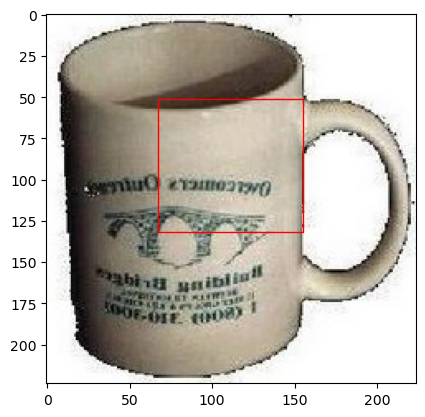

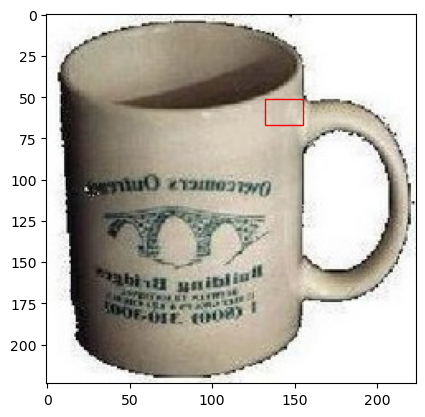

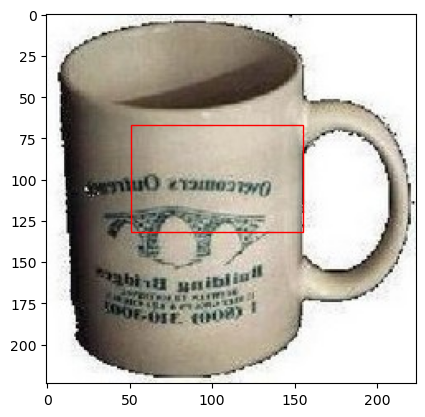

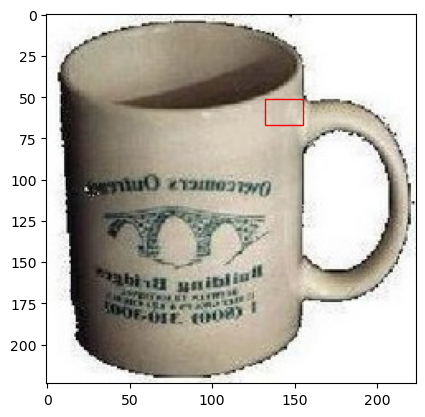

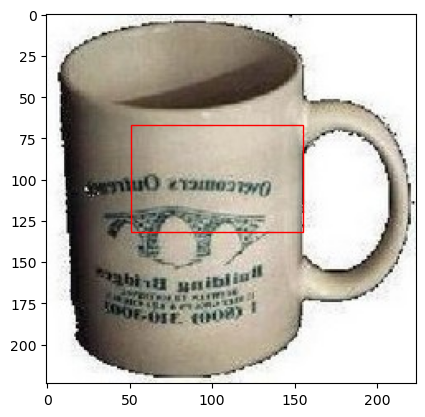

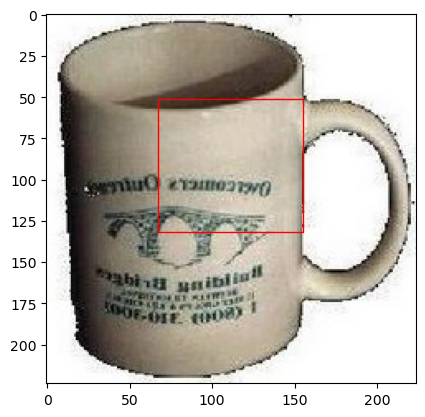

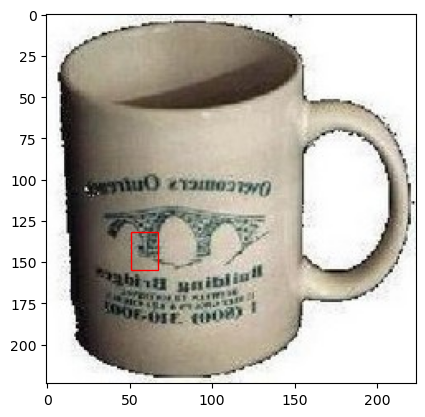

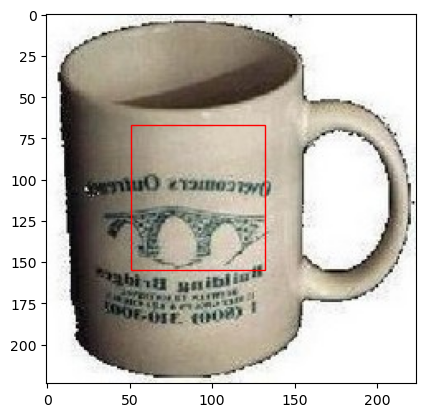

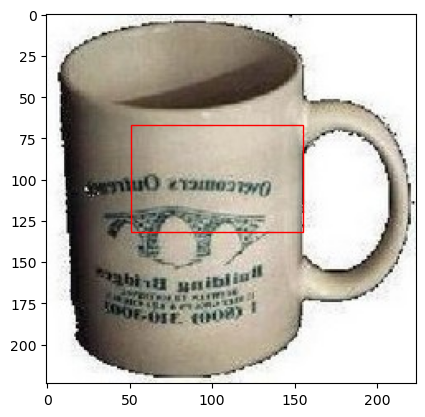

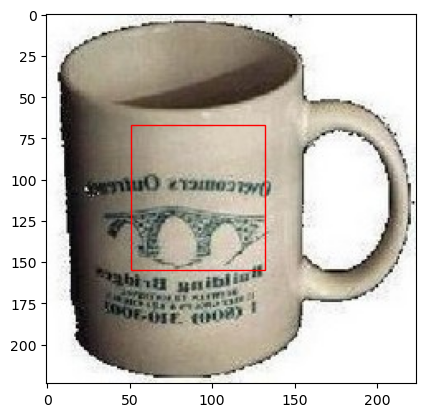

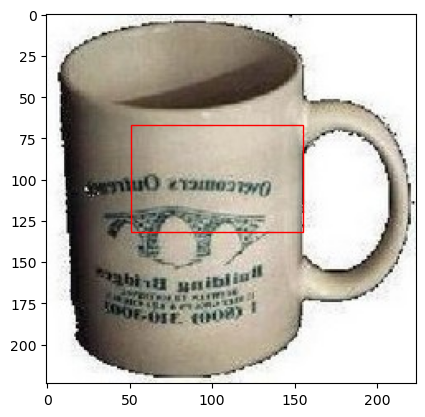

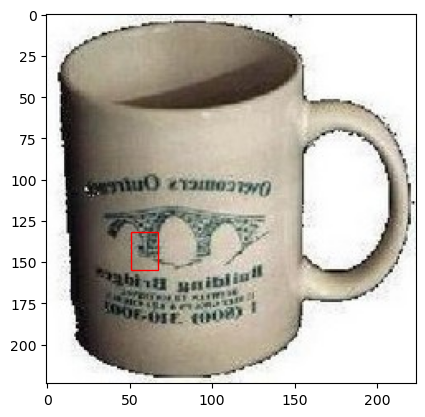

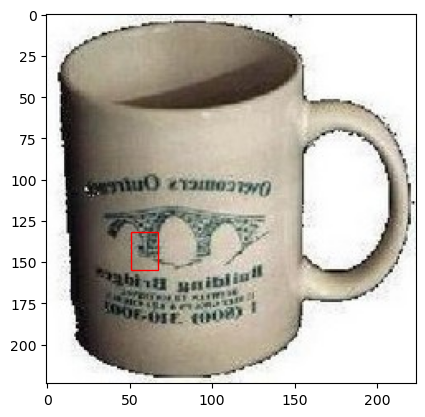

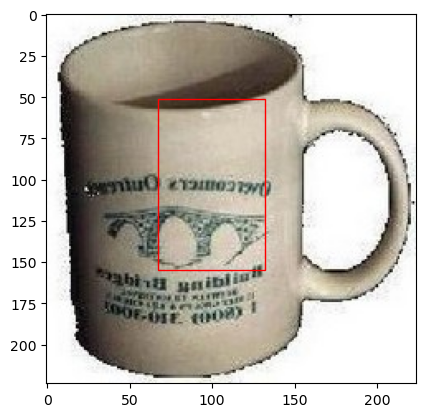

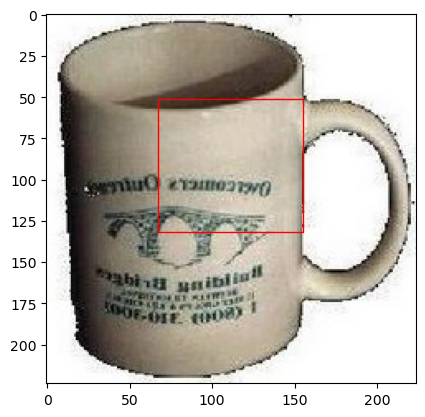

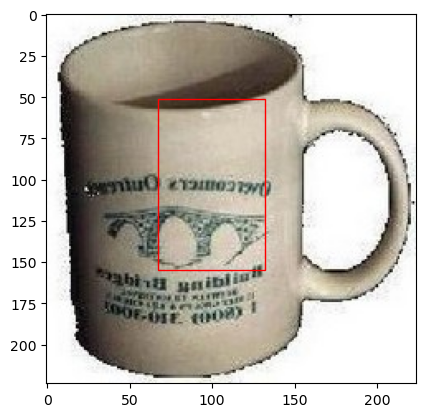

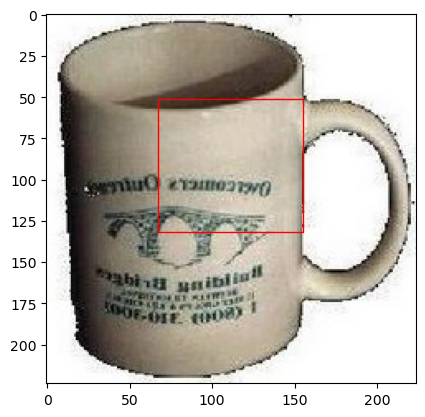

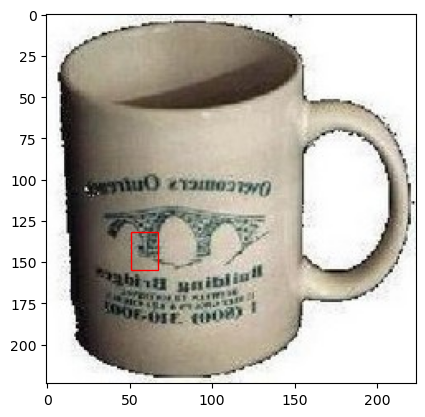

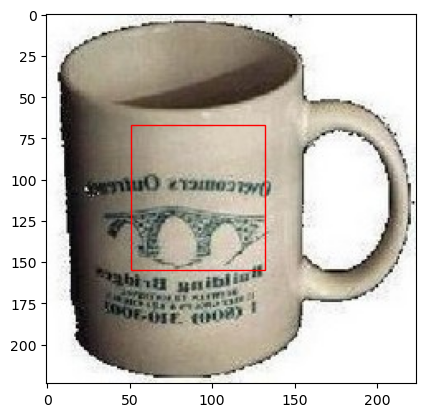

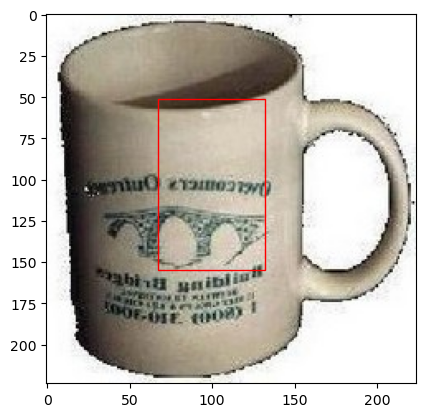

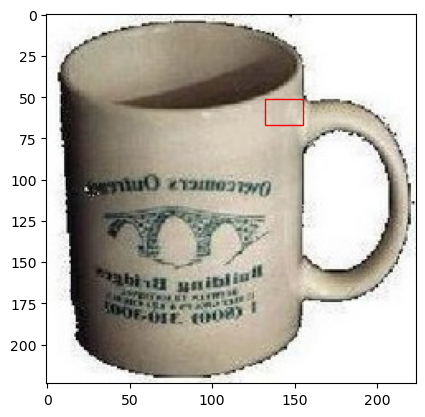

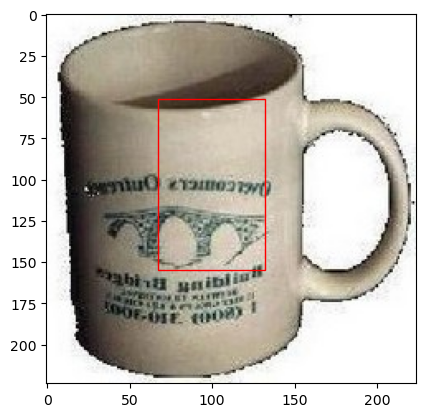

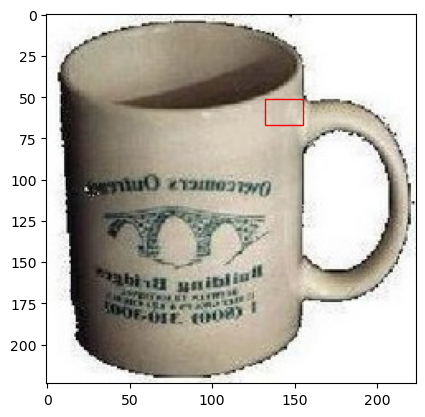

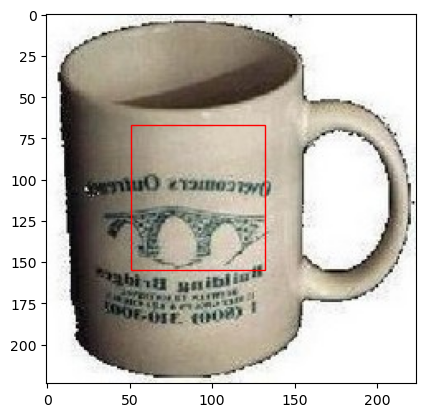

In [300]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


def collate_fn(batch):
    return tuple(zip(*batch))

    
#cup_dataset = CupDataset(dataframe=data, root_dir='C:/Users/denis/Desktop/HNS/Git/svec-safar-HNS/Zadanie4/cup_images/', transforms_2=get_transform())

cup_dataset = CupDataset(dataframe=data, root_dir='C:/Users/denis/Desktop/HNS/Git/svec-safar-HNS/Zadanie4/cup_images/')


# Create a data loader

indices = np.random.permutation(len(cup_dataset)).tolist()

# train_data = torch.utils.data.Subset(cup_dataset, indices[:])

# data_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)

train_size = int(0.8 * len(cup_dataset))
val_size = len(cup_dataset) - train_size

# Split the dataset
train_dataset = torch.utils.data.Subset(cup_dataset, indices[:train_size])
val_dataset = torch.utils.data.Subset(cup_dataset, indices[train_size:])

# Define data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
cup_dataset.test_box_permutations(105)

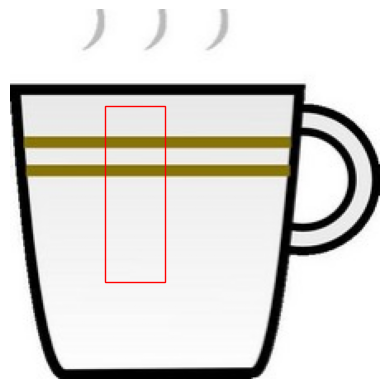

In [301]:

for images, targets in train_loader:

    if len(images) > 0:
        first_image = images[0]
        first_target = targets[0]

        box = first_target['boxes'][0].cpu().numpy() 

        show_tensor_image_with_box(first_image, box)
        break 


In [302]:
import torchvision.models.detection as models

model = models.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\denis\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\denis\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [303]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
   
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



AssertionError: All bounding boxes should have positive height and width. Found invalid box [214.28570556640625, 285.71429443359375, 175.0, 482.1428527832031] for target at index 0.